In [165]:
import os
import pickle
from pathlib import Path
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pybullet as p
import tensorflow as tf
from scipy.spatial import ConvexHull

from ravens.utils import utils


In [161]:
COLORS = {
    "blue": [078.0 / 255.0, 121.0 / 255.0, 167.0 / 255.0],
    "red": [255.0 / 255.0, 087.0 / 255.0, 089.0 / 255.0],
    "green": [089.0 / 255.0, 169.0 / 255.0, 079.0 / 255.0],
    "orange": [242.0 / 255.0, 142.0 / 255.0, 043.0 / 255.0],
    "yellow": [237.0 / 255.0, 201.0 / 255.0, 072.0 / 255.0],
    "purple": [176.0 / 255.0, 122.0 / 255.0, 161.0 / 255.0],
    "pink": [255.0 / 255.0, 157.0 / 255.0, 167.0 / 255.0],
    "cyan": [118.0 / 255.0, 183.0 / 255.0, 178.0 / 255.0],
    "brown": [156.0 / 255.0, 117.0 / 255.0, 095.0 / 255.0],
    "gray": [186.0 / 255.0, 176.0 / 255.0, 172.0 / 255.0],
}


def plot_success(
    ylabel,
    xlabel,
    data,
    ax,
    xlim=[-np.inf, 0],
    xticks=None,
    ylim=[np.inf, -np.inf],
    show_std=True,
):
    """Plot frame data."""
    # Data is a dictionary that maps experiment names to tuples with 3
    # elements: x (size N array) and y (size N array) and y_std (size N array)

    # Get data limits.
    for name, (x, y, _) in data.items():
        y = np.array(y)
        xlim[0] = max(xlim[0], np.min(x))
        xlim[1] = max(xlim[1], np.max(x))
        ylim[0] = min(ylim[0], np.min(y))
        ylim[1] = max(ylim[1], np.max(y))

    # Draw background.
    # ax.set_title(title, fontsize=14)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.grid(True, linestyle="-", color=[0.8, 0.8, 0.8])
    _ax = plt.gca()
    for axis in ["top", "bottom", "left", "right"]:
        _ax.spines[axis].set_color("#000000")
    plt.rcParams.update({"font.size": 14})
    plt.rcParams["mathtext.default"] = "regular"
    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42

    # Draw data.
    color_iter = 0
    for name, (x, y, std) in data.items():
        x, y, std = np.float32(x), np.float32(y), np.float32(std)
        upper = np.clip(y + std, ylim[0], ylim[1])
        lower = np.clip(y - std, ylim[0], ylim[1])
        color = COLORS[list(COLORS.keys())[color_iter]]
        if show_std:
            ax.fill_between(
                x, upper, lower, color=color, linewidth=0, alpha=0.3, label=name
            )
        ax.plot(x, y, color=color, linewidth=2, marker="o", alpha=1.0)
        color_iter += 1

    if xticks:
        ax.set_xticks(ticks=range(len(xticks)), labels=xticks)
    ax.legend(loc="lower right", fontsize=14)
    plt.tight_layout()


def plot_points(ax, place_positions, draw_convex=True):
    ax.plot(
        place_positions[-1][:, 0],
        place_positions[-1][:, 1],
        "x",
        color=COLORS["green"],
        alpha=1,
    )
    if draw_convex:
        hull = ConvexHull(place_positions[-1])
        for simplex in hull.simplices:
            ax.plot(
                place_positions[-1][simplex, 0],
                place_positions[-1][simplex, 1],
                "--",
                color=COLORS["green"],
                alpha=0.7,
            )
    ax.plot(
        place_positions[1][:, 0],
        place_positions[1][:, 1],
        "o",
        color=COLORS["blue"],
    )
    ax.plot(
        place_positions[0][:, 0], place_positions[0][:, 1], "o", color=COLORS["red"]
    )
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    plt.tight_layout()


def plot_orientations(ax, place_orientations):
    ax.plot(
        np.real(np.exp(1j * place_orientations[-1])),
        np.imag(np.exp(1j * place_orientations[-1])),
        "x",
        color=COLORS["green"],
        alpha=1,
    )
    ax.plot(
        np.real(np.exp(1j * place_orientations[1])),
        np.imag(np.exp(1j * place_orientations[1])),
        "o",
        color=COLORS["blue"],
    )
    ax.plot(
        np.real(np.exp(1j * place_orientations[0])),
        np.imag(np.exp(1j * place_orientations[0])),
        "o",
        color=COLORS["red"],
    )
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    plt.tight_layout()


In [162]:
def compute_score_per_step(path_to_predictions, name):
    curve = {"score": [], "nb_action": []}
    for fname in tf.io.gfile.listdir(str(path_to_predictions)):
        fname = os.path.join(path_to_predictions, fname)
        if name in fname and ".pkl" in fname:
            n_steps = int(fname[(fname.rfind("-") + 1) : -4])
            data = pickle.load(open(fname, "rb"))
            rewards = []
            actions = []
            for reward, action in data:
                rewards.append(reward)
                actions.append(len(action))
            score = np.mean(rewards)
            std = np.std(rewards)
            curve["score"].append((n_steps, score, std))

            nb_action = np.mean(actions)
            std = np.std(nb_action)
            curve["nb_action"].append((n_steps, nb_action, std))

        curve["score"].sort()
        curve["nb_action"].sort()
    return {k: np.array(v) for k, v in curve.items()}


/home/matias/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempting to set identical bottom == top == 2.0 results in singular transformations; automatically expanding.


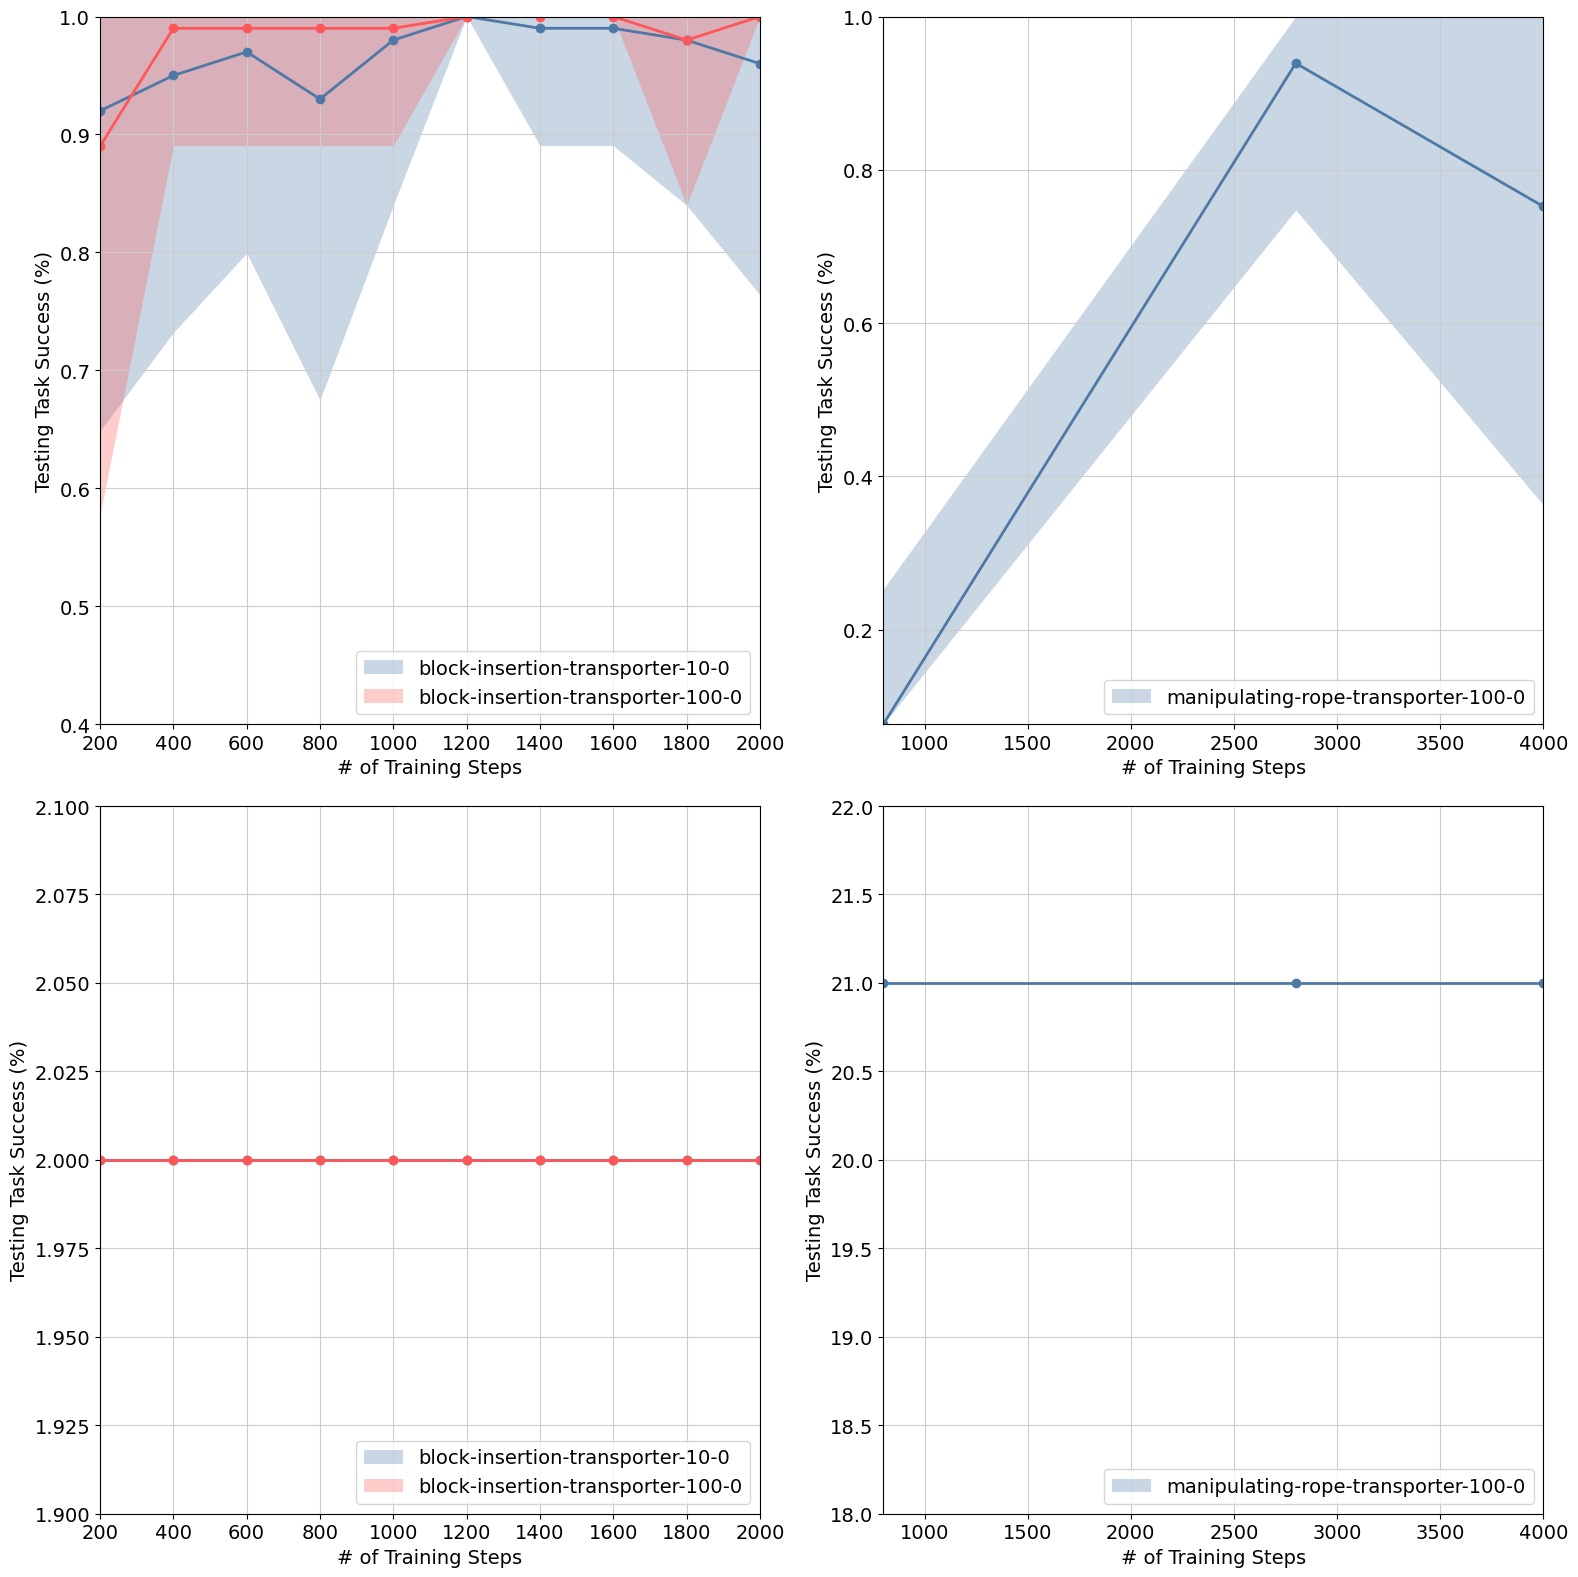

In [163]:
task = "block-insertion"
agent = "transporter"
train_run = 0
logs = {"score": {}, "nb_action": {}}

np.random.seed(train_run)
tf.random.set_seed(train_run)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
ylabel = "Testing Task Success (%)"
xlabel = "# of Training Steps"

for n_demos in [10, 100]:
    path_to_predictions = f"predictions/{task}-{agent}-{n_demos}-{train_run}/"
    name = f"{task}-{agent}-{n_demos}-{train_run}"

    # Load and print results to console.
    curve = compute_score_per_step(path_to_predictions, name)
    # Plot results over training steps.
    logs["score"][name] = (
        curve["score"][:, 0],
        curve["score"][:, 1],
        curve["score"][:, 2],
    )
    logs["nb_action"][name] = (
        curve["nb_action"][:, 0],
        curve["nb_action"][:, 1],
        curve["nb_action"][:, 2],
    )
plot_success(ylabel, xlabel, data=logs["score"], ax=axs[0, 0], ylim=[0.4, 1], xlim=[0, 1000])
plot_success(ylabel, xlabel, data=logs["nb_action"], ax=axs[1, 0], xlim=[0, 1000])

task = "manipulating-rope"
logs = {"score": {}, "nb_action": {}}
n_demos = 100
path_to_predictions = f"predictions/{task}-{agent}-{n_demos}-{train_run}/"
name = f"{task}-{agent}-{n_demos}-{train_run}"

# Load and print results to console.
curve = compute_score_per_step(path_to_predictions, name)
# Plot results over training steps.
logs["score"][name] = (
    curve["score"][:, 0],
    curve["score"][:, 1],
    curve["score"][:, 2],
)
logs["nb_action"][name] = (
    curve["nb_action"][:, 0],
    curve["nb_action"][:, 1],
    curve["nb_action"][:, 2],
)

plot_success(ylabel, xlabel, data=logs["score"], ax=axs[0, 1], ylim=[0.4, 1])
plot_success(ylabel, xlabel, data=logs["nb_action"], ax=axs[1, 1], ylim=[18, 22])


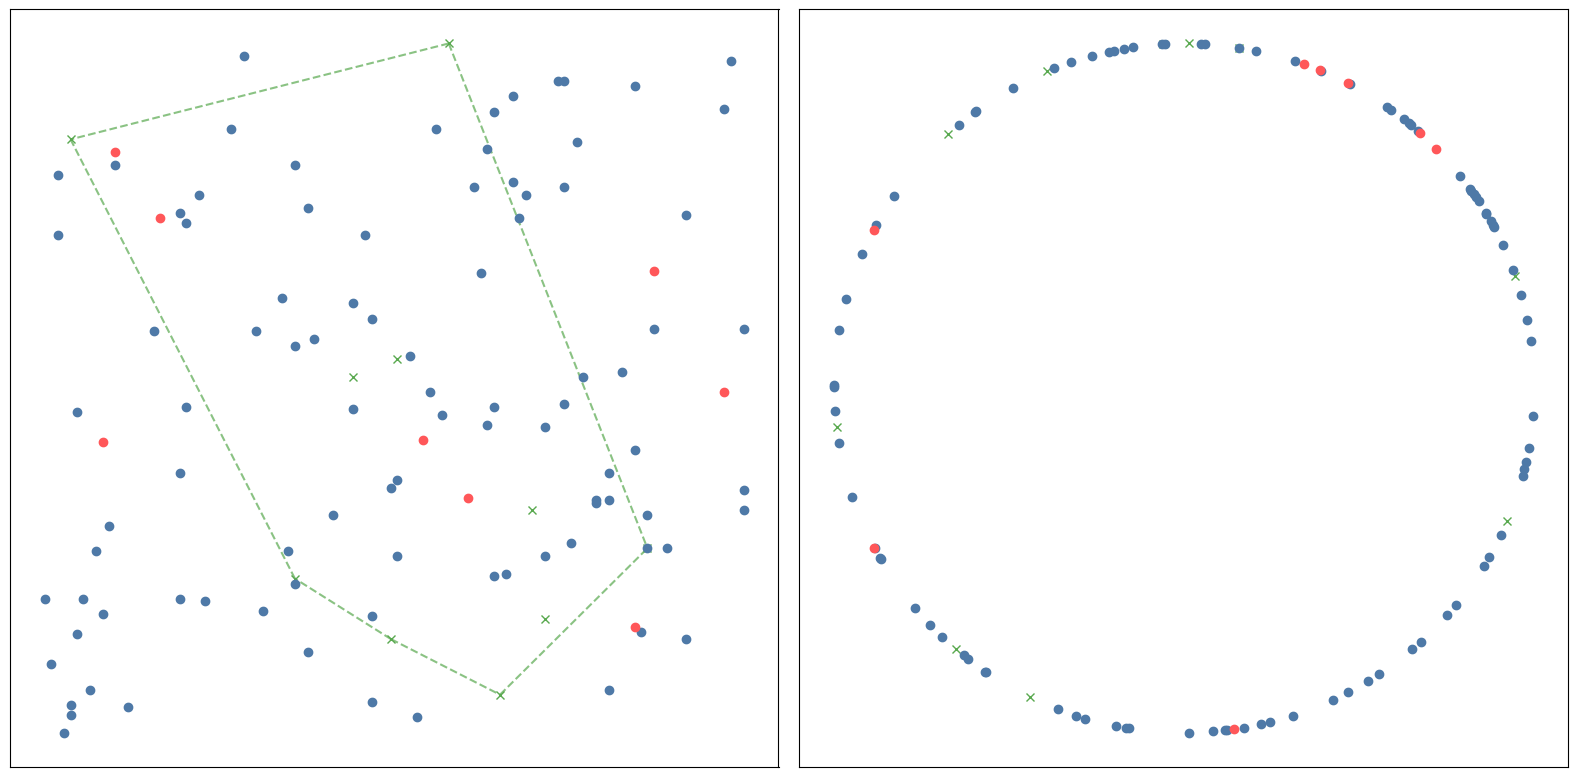

In [77]:
task = "block-insertion"
agent = "transporter"
train_run = 0
n_demos = 10

np.random.seed(train_run)
tf.random.set_seed(train_run)

episodes = np.random.choice(1000, n_demos, False)
path_to_infos = Path(f"dataset/{task}-train/info/")

data = pickle.load(
    open(
        os.path.join(
            f"predictions/{task}-{agent}-{n_demos}-{train_run}/",
            f"{task}-{agent}-{n_demos}-{train_run}-200.pkl",
        ),
        "rb",
    )
)

place_positions = {-1: [], 0: [], 1: []}
place_orientations = {-1: [], 0: [], 1: []}
for episode in episodes:
    info_path = [
        f for f in path_to_infos.glob("{:>6}*.pkl".format(episode).replace(" ", "0"))
    ][0]
    with open(info_path, "rb") as file:
        info = pickle.load(file)
    place_positions[-1].append(info[0][6][0])
    place_orientations[-1].append(p.getEulerFromQuaternion(info[0][6][1]))

for episode_info in data:
    place_positions[episode_info[0]].append(episode_info[1][6][0])
    place_orientations[episode_info[0]].append(
        p.getEulerFromQuaternion(episode_info[1][6][1])
    )

place_positions = {k: np.array(v)[:, :2] for k, v in place_positions.items()}
place_orientations = {k: np.array(v)[:, 2] for k, v in place_orientations.items()}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_points(axs[0], place_positions, draw_convex=True)
plot_orientations(axs[1], place_orientations)


In [167]:
task = "manipulating-rope"
agent = "transporter"
train_run = 0
n_demos = 10

np.random.seed(train_run)
tf.random.set_seed(train_run)

path_to_infos = Path(f"dataset/{task}-test/info/")
info_paths = [f for f in path_to_infos.glob("**/*") if f.is_file()]
for info_path in info_paths:
    with open(info_path, "rb") as file:
        info = pickle.load(file)
    pprint(info)
    raise ValueError
    # if len(info) > 2:
    #     print(info_path)
    #     raise ValueError


[{5: ((0.478125, 0.265625, 0.0),
      (-0.0, -0.0, 0.2745957518707489, 0.9615597605216943),
      (0.28284271247461906, 0.01, 0.001)),
  6: ((0.5975108111461273, -0.07395614430024099, 0.004034906635192179),
      (-0.11540696134812459,
       0.6941446333111585,
       0.11641204029567206,
       0.7009227476633275),
      (0.0075, 0.0, 0.0)),
  7: ((0.6108890879061042, -0.069382243896459, 0.004168201964438066),
      (0.4773703441993513,
       -0.5039842757217413,
       0.5226098269829066,
       -0.49497108303932374),
      (0.0075, 0.0, 0.0)),
  8: ((0.6250038697730356, -0.07014978718674099, 0.0046872442512075506),
      (0.6206552448533031,
       -0.1978472980714497,
       -0.23014043176499877,
       0.7229653486502193),
      (0.0075, 0.0, 0.0)),
  9: ((0.6169242953824985, -0.08155472317998062, 0.006828034084105547),
      (0.690843785241047,
       0.35118702267037943,
       -0.6246862534256501,
       -0.09575815517626249),
      (0.0075, 0.0, 0.0)),
  10: ((0.60376570950

ValueError: 

In [74]:
all_n_steps = []
path_to_checkpoints = Path("checkpoints/manipulating-rope-transporter-10-0")
files = [f for f in path_to_checkpoints.glob("**/*") if f.is_file()]
for file in files:
    # print(file)
    n_steps = int(str(file.stem).split("-")[-1])
    if n_steps == 3050 or n_steps % 400 == 0:
        if n_steps not in all_n_steps:
            all_n_steps.append(n_steps)
            print(
                f"python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps={n_steps} --data_dir=../dataset/ --root_dir=../"
            )


python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=2800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=3050 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=1200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environ